# Data Challenge ANCAP
Federica Bouvier, Sofia Borrazas, María del Pilar Nogues & Guillermo Robatto.

## Desafio
Lograr una estimación de la variable DQO en la Cámara de Aforo PTE a partir de los datos que se miden en forma continua, de forma de poder tomar acciones correctivas más rápidamente en caso de que se estimara que la variable no se encuentra en rango aceptable, sin tener que esperar a contar con los resultados de los análisis químicos correspondientes. Un efluente con alta DQO puede tener efectos perjudiciales significativos en la calidad del agua y en la salud de los ecosistemas acuáticos, de allí el interés en mejorar el control de dicha variable para mantenerla en rango aceptable.


### Registros disponibles

#### a)      Archivo con Datos continuos de la cámara de aforo

Se cuenta con registros conteniendo datos determinados automáticamente a intervalos de un minuto. Se dispone de más de cuatro años de registros automáticos continuos aproximadamente.

#### b)      Datos diarios cámara aforo PTE (Planta de Tratamiento de Efluentes):

Se cuenta con registros de los análisis de la muestra diaria (normalmente de lunes a viernes). Se dispone aproximadamente de 1700 datos de resultados de ensayo con determinación de DQO.


### Algunos conceptos clave:

#### Conductividad

La conductividad es la capacidad que posee una solución acuosa de conducir la corriente eléctrica, dicha habilidad depende de la concentración total de iones, de la movilidad y valencia de los mismos, así como también de la temperatura a la que se realiza la medida.

 
#### DQO (Demanda Química de Oxígeno)

La Demanda Química de Oxígeno (DQO) es la medida de oxígeno equivalente a la materia orgánica que es susceptible a ser oxidada por un oxidante químico específico fuerte, en condiciones específicas de temperatura y tiempo. La cantidad de oxidante consumido se expresa en términos de su equivalencia de oxígeno. Los componentes tanto orgánicos como inorgánicos de la muestra son pasibles de oxidación, pero en la mayoría de los casos predominan los componentes orgánicos y son de mayor interés.


#### Sólidos Suspendidos

El término Sólidos Suspendidos se aplica a la parte de los sólidos totales retenida por un filtro de fibra de vidrio.

El término Sólidos Suspendidos Totales se aplica a los residuos de material que quedan en un filtro después de la evaporación en estufa a 103 - 105 °C.

Los Sólidos Suspendidos Fijos corresponden a los residuos remanentes del incinerado a 550 °C y los Sólidos Suspendidos Volátiles corresponden a los compuestos perdidos durante la calcinación a 550 °C (que dan una aproximación de la cantidad de materia orgánica presente en la muestra).


#### Turbidez

La turbidez en el agua es causada por material en suspensión o coloidal provenientes de arcillas, materiales orgánicos e inorgánicos finamente divididos, plancton y otros organismos microscópicos. Es una expresión de la propiedad óptica que causa disminución en la transmisión de la luz a través de la muestra. Se mide en unidades de turbidez nefelométrica (NTU).

### ¿Cómo se evaluarán las soluciones?

Las soluciones (notebooks) que se presenten serán evaluadas considerando:

- el Root-Mean-Squared-Error (RMSE) entre el valor real de la variable medida en laboratorio y el valor predicho entregado para cada una de las variables del desafío.

- la cantidad de predicciones que se encuentre en el rango del valor real correspondiente a esa predicción  +- 10%.

In [139]:
# !pip install missingno

In [140]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
# lo corri de kaggle pero si lo hacen de sus compus pongan aca el archivo relativo del repo lol asi ya queda
data_lab = pd.read_csv('/kaggle/input/data-ancap2/Ensayos_Laboratorio_Camara_ Aforo_PTE(in).csv', encoding='latin1', sep = ';')
data_camara = pd.read_csv('/kaggle/input/camara-de-aforo/Camara_ Aforo_PTE_DatosContinuos(in).csv', encoding='latin1', sep=';')
estimacion_dqo = pd.read_csv('/kaggle/input/data-ancap2/Estimacion_DQO_Camara_ Aforo_PTE(in).csv', sep = ';')

/tmp/ipykernel_30/477174419.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_camara = pd.read_csv('/kaggle/input/camara-de-aforo/Camara_ Aforo_PTE_DatosContinuos(in).csv', encoding='latin1', sep=';')


Dataframes generados:
- Data lab -> Información de los ensayos de laboratorio en la camara de aforo
- Data camara -> Información de la camara de aforo
- Estimacion DQO -> Dataset test de predicciones

# Exploratory Data Analysis
(arranco solo del data lab pq el otro dataset no lo importe, desp es solo ir agregandolo en cada cat)

In [142]:
data_lab.describe(include = 'all')

,Fecha,Hora,Temperatura (ºC),pH,Turbiedad (NTU),DQO \n(mg O2/L)
count,588,579,581.000000,580.000000,576.000000,588
unique,588,42,NaN,NaN,NaN,129
top,07/10/2021,9:00,NaN,NaN,NaN,<100
freq,1,261,NaN,NaN,NaN,25
mean,NaN,NaN,28.649570,7.294897,7.221007,NaN
std,NaN,NaN,3.781013,0.498734,5.370371,NaN
min,NaN,NaN,19.000000,6.020000,1.100000,NaN
25%,NaN,NaN,26.100000,7.000000,3.830000,NaN
50%,NaN,NaN,29.000000,7.290000,5.755000,NaN
75%,NaN,NaN,31.500000,7.620000,9.002500,NaN


In [143]:
data_camara.describe(include = 'all')

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
count,1048575,1048575.0,1048575,1048575,1048575
unique,1048575,107103.0,5754,115160,250652
top,2021-10-06 15:16:00.000,0.0,0.00000,0.00000,103.140.002
freq,1,22223.0,26950,13652,24807


In [144]:
data_lab.dtypes

Fecha                object
Hora                 object
Temperatura (ºC)    float64
pH                  float64
Turbiedad (NTU)     float64
DQO \n(mg O2/L)      object
dtype: object

Transformaciones a las columnas del dataframe data_lab

In [145]:
# La target esta contaminada de un string, lo reemplace con 50 pero tenemos que ver que funcione mejor
data_lab['DQO \n(mg O2/L)'] = data_lab['DQO \n(mg O2/L)'].replace('<100', 50)
data_lab['DQO \n(mg O2/L)'] = pd.to_numeric(data_lab['DQO \n(mg O2/L)'], errors='coerce')

# Fecha y hora estan en formato incorrecto + nueva col completa
data_lab = data_lab.dropna(subset=['Fecha', 'Hora'])
data_lab['Fecha'] = pd.to_datetime(data_lab['Fecha'], format='%d/%m/%Y', errors='coerce')
data_lab['Hora'] = data_lab['Hora'].astype(str).str.replace('.', ':', regex=False)

data_lab['Fecha_Hora'] = pd.to_datetime(
    data_lab['Fecha'].astype(str) + ' ' + data_lab['Hora'].astype(str),
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

In [146]:
data_camara.dtypes

TimeStamp                                   object
AE82128 - pH Cámara de Aforo  (-)           object
AE82129 - Temperatura Cámara de Aforo       object
FE82130 - Caudal Cámara de Aforo  (m3/h)    object
Turbidez Cámara de Aforo Biológico          object
dtype: object

Transformaciones a las columnas del dataframe data camara

In [147]:
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,767.0,3.565.000,2.884.444,1.619.123
1,2021-10-06 15:17:00.000,766.208,3.579.583,3.110.833,1.399.667
2,2021-10-06 15:18:00.000,763.222,3.583.333,3.271.333,1.497.556
3,2021-10-06 15:19:00.000,760.556,3.590.000,3.302.667,1.826.667
4,2021-10-06 15:20:00.000,750.042,3.571.667,2.996.833,20.374.000


In [148]:
def corregir_valores(columna, shift_decimal):
    """
    Corrige los valores numéricos moviendo el punto decimal según el desplazamiento especificado,
    manejando datos corruptos o inconsistentes.
    
    Parámetros:
    - columna: pd.Series. La columna con valores a corregir.
    - shift_decimal: int. Número de posiciones para mover el punto decimal (+ hacia la derecha, - hacia la izquierda).
    
    Retorna:
    - pd.Series con los valores corregidos o NaN si el valor no es válido.
    """
    def transformar_valor(valor):
        try:
            if pd.isna(valor):  # manejo de nulos
                return None
            valor_str = str(valor)
            punto_pos = valor_str.find('.')  # busca la posicion del punto
            if punto_pos == -1:  # maneja casos donde hay 
                return float(valor_str)
            # nueva pos del punto con el shift
            nueva_pos = max(0, punto_pos + shift_decimal)  # dentro del indice
            valor_sin_punto = valor_str.replace('.', '')
            nuevo_valor = valor_sin_punto[:nueva_pos] + '.' + valor_sin_punto[nueva_pos:]
            return float(nuevo_valor)
        except ValueError:
            return None # none para valores que no se puedan procesar
    
    return columna.apply(transformar_valor)

In [149]:
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,767.0,3.565.000,2.884.444,1.619.123
1,2021-10-06 15:17:00.000,766.208,3.579.583,3.110.833,1.399.667
2,2021-10-06 15:18:00.000,763.222,3.583.333,3.271.333,1.497.556
3,2021-10-06 15:19:00.000,760.556,3.590.000,3.302.667,1.826.667
4,2021-10-06 15:20:00.000,750.042,3.571.667,2.996.833,20.374.000


In [150]:
# aplicacion
data_camara['AE82128 - pH Cámara de Aforo  (-)'] = corregir_valores(
    data_camara['AE82128 - pH Cámara de Aforo  (-)'], -2)

data_camara['AE82129 - Temperatura Cámara de Aforo'] = corregir_valores(
    data_camara['AE82129 - Temperatura Cámara de Aforo'], 1)

data_camara['FE82130 - Caudal Cámara de Aforo  (m3/h)'] = corregir_valores(
    data_camara['FE82130 - Caudal Cámara de Aforo  (m3/h)'], 1)

data_camara['Turbidez Cámara de Aforo Biológico'] = corregir_valores(
    data_camara['Turbidez Cámara de Aforo Biológico'], 3)

# Verificar los resultados
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,7.67000,35.65000,28.84444,1619.123
1,2021-10-06 15:17:00.000,7.66208,35.79583,31.10833,1399.667
2,2021-10-06 15:18:00.000,7.63222,35.83333,32.71333,1497.556
3,2021-10-06 15:19:00.000,7.60556,35.90000,33.02667,1826.667
4,2021-10-06 15:20:00.000,7.50042,35.71667,29.96833,20374.000


In [152]:
data_camara['TimeStamp'] = pd.to_datetime(data_camara['TimeStamp'])
data_camara.describe()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
count,1048575,1.048016e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2022-10-05 17:22:59.999997696,6.966924e+00,2.886436e+01,1.135672e+02,1.687689e+05
min,2021-10-06 15:16:00,0.000000e+00,-6.400000e+03,-9.820000e+03,-8.000000e+03
25%,2022-04-06 16:19:30,6.912500e+00,2.777500e+01,3.254667e+01,1.722000e+03
50%,2022-10-05 17:23:00,7.145000e+00,2.999444e+01,3.968500e+01,1.035883e+04
75%,2023-04-05 18:26:30,7.357480e+00,3.180000e+01,4.973292e+01,1.031400e+05
max,2023-10-04 19:30:00,9.941670e+00,9.066670e+03,9.996670e+03,9.998750e+05
std,NaN,1.177824e+00,2.959445e+01,6.603009e+02,2.925215e+05


## Missing values

<Axes: >

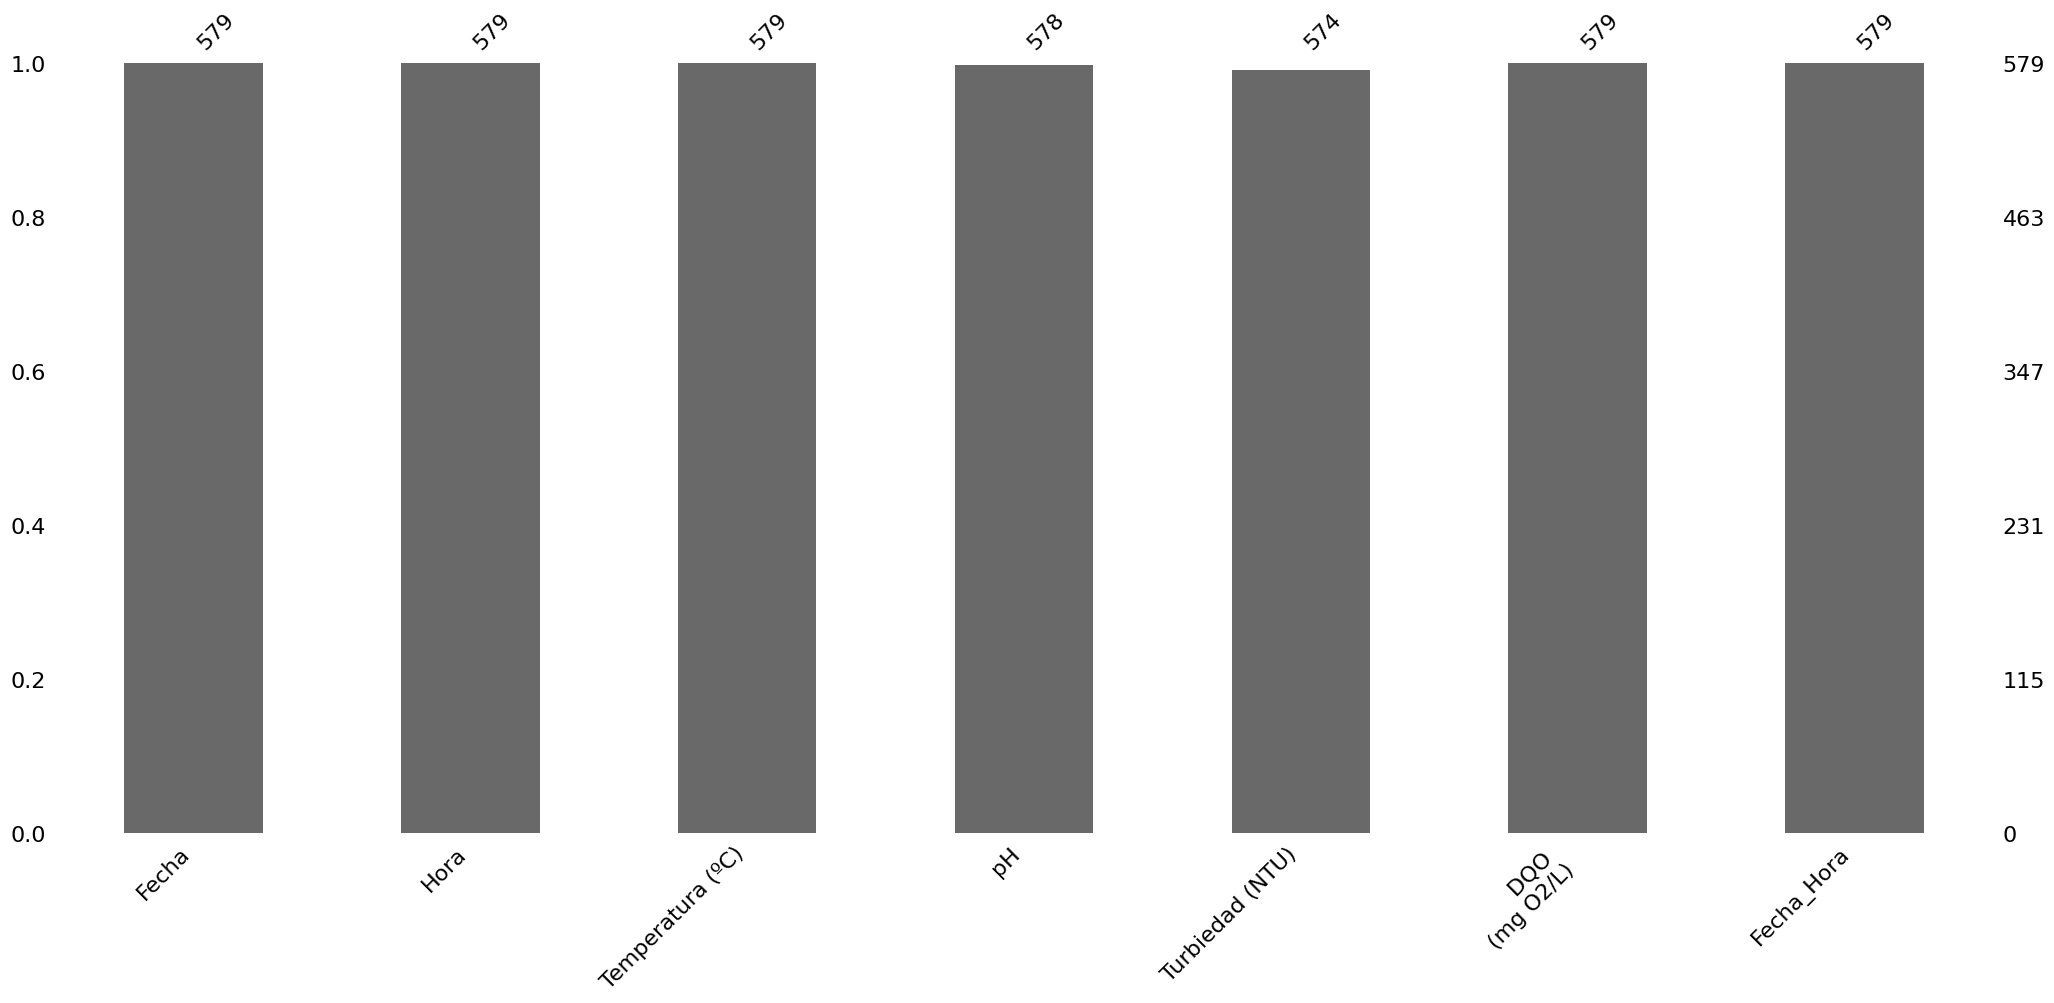

In [153]:
msno.bar(data_lab)

<Axes: >

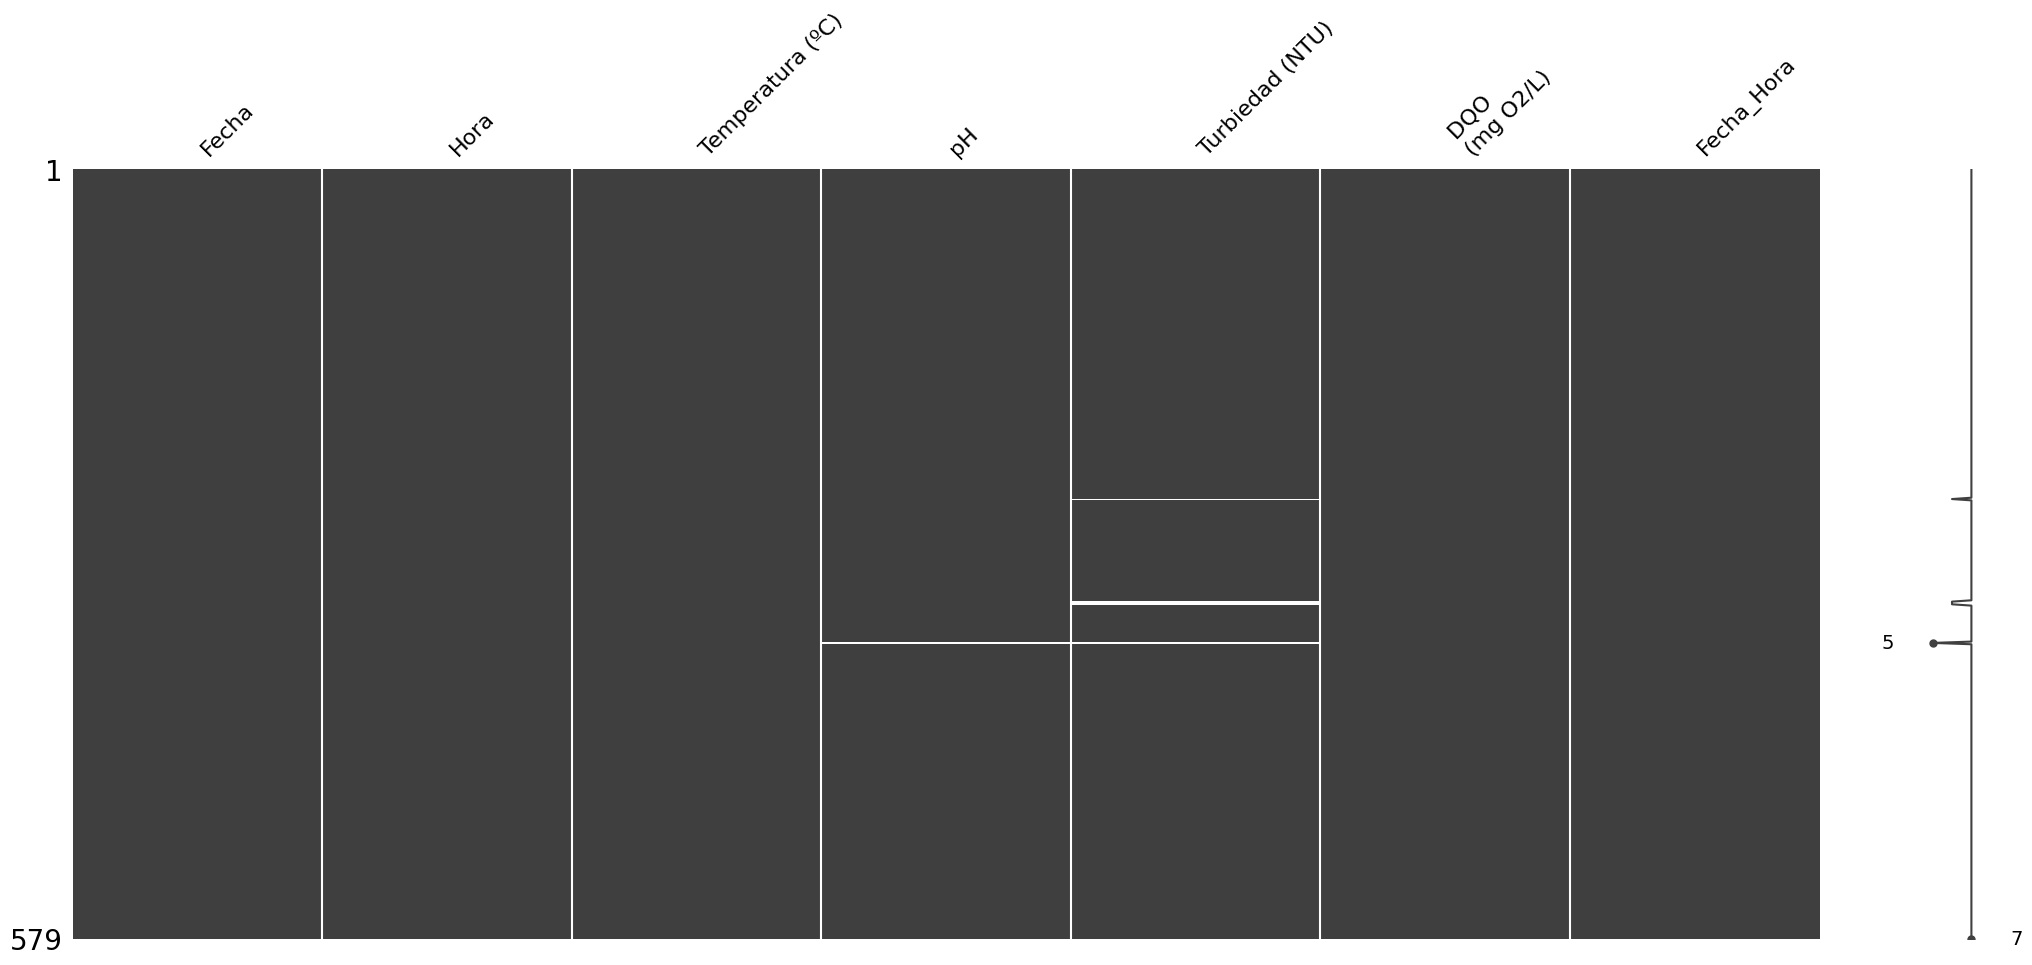

In [154]:
msno.matrix(data_lab)

<Axes: >

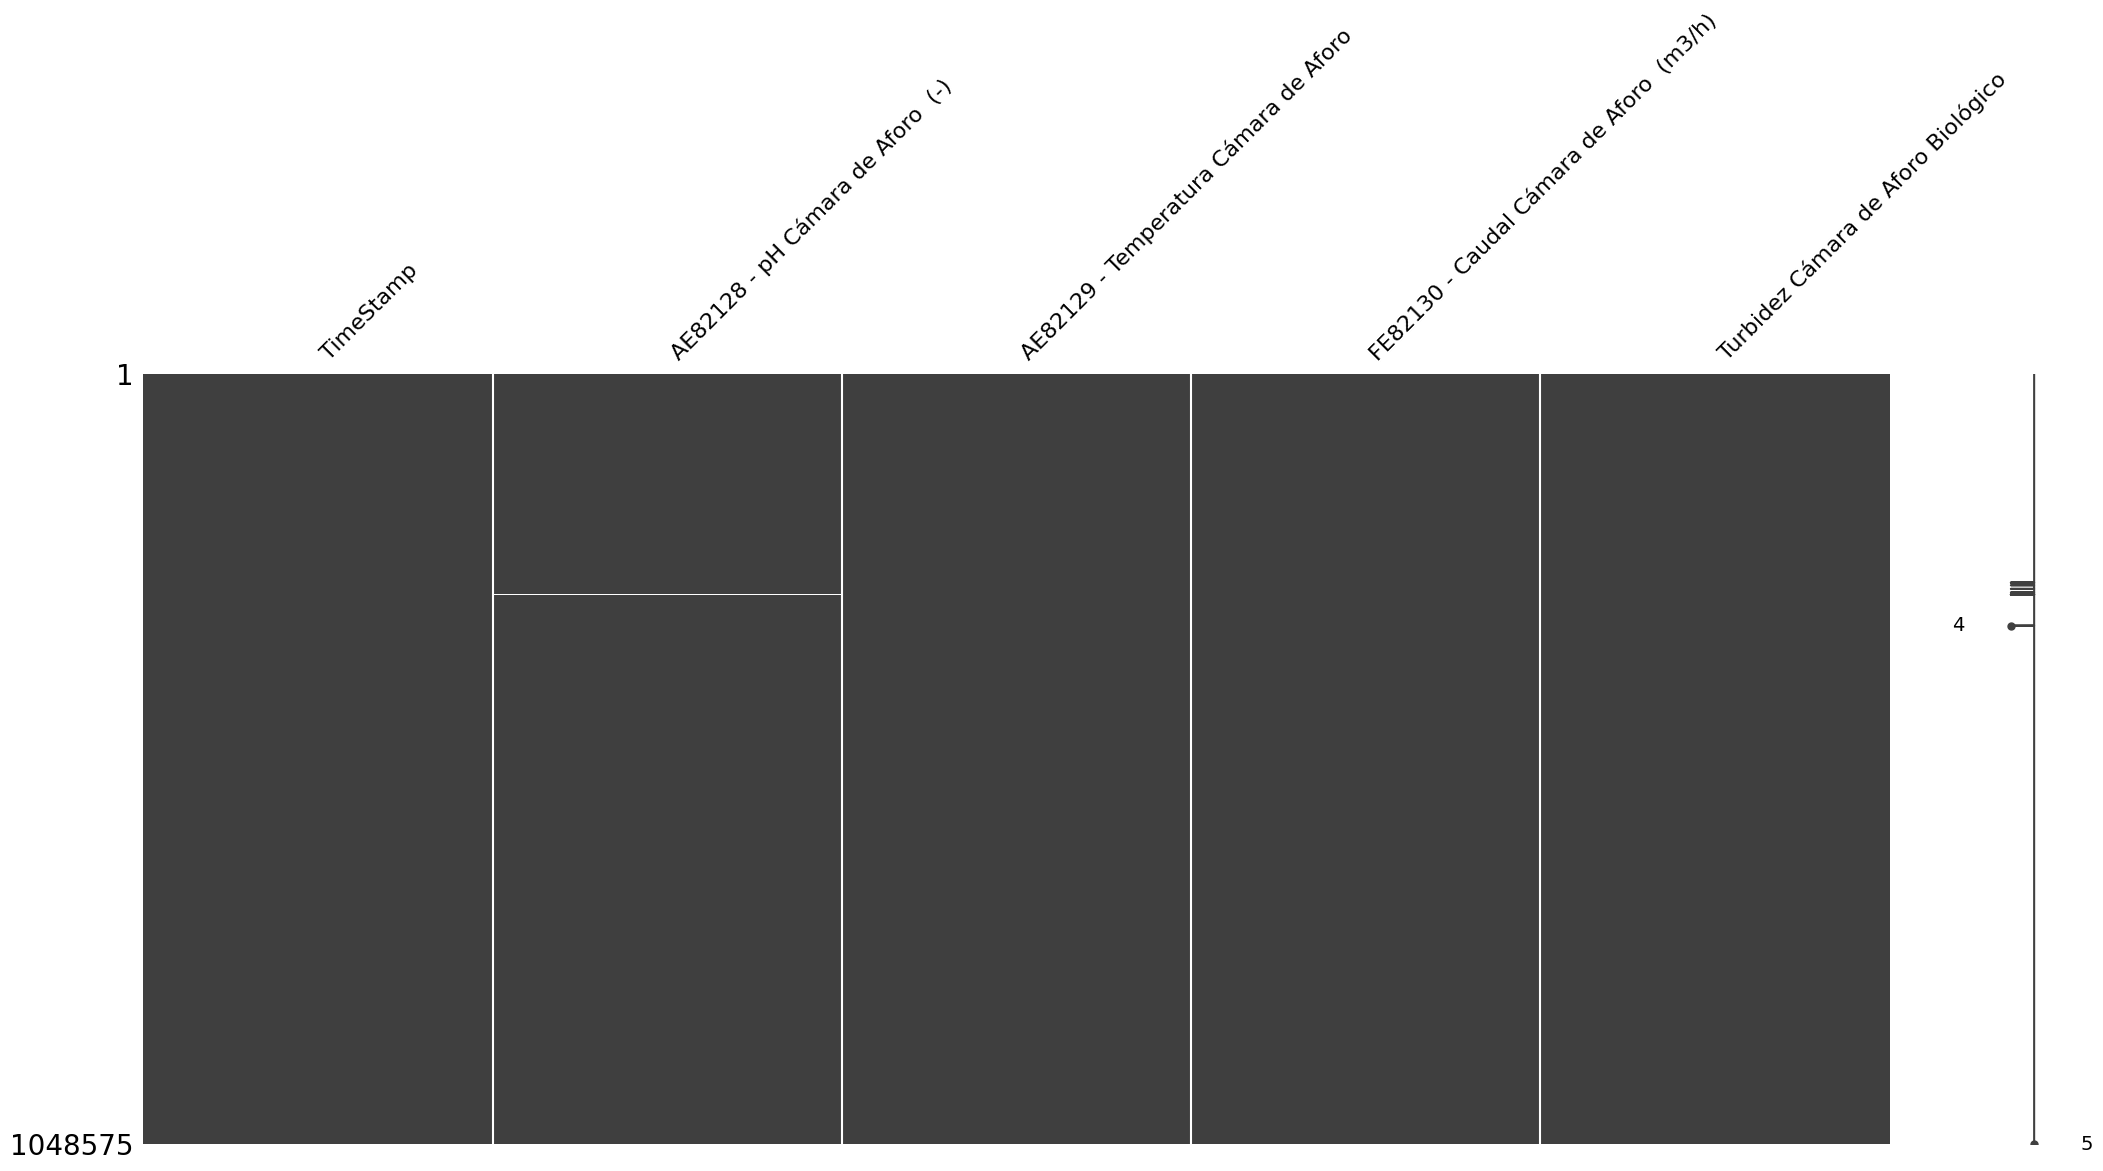

In [155]:
msno.matrix(data_camara)

## Distribuciones

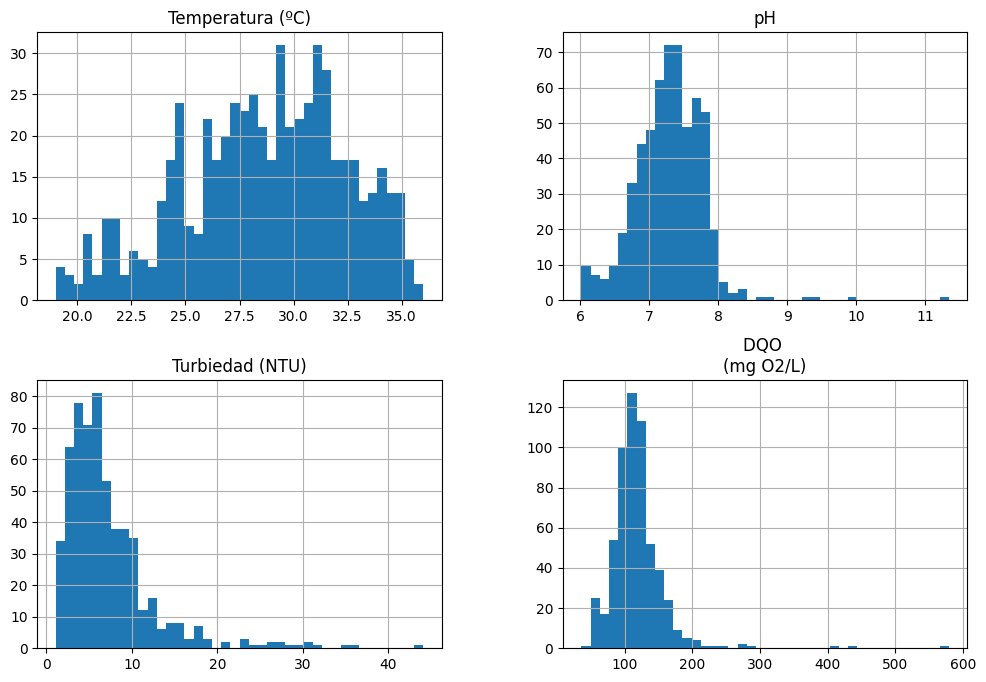

In [156]:
data_lab.select_dtypes(include=['number']).hist(bins=40, figsize=(12, 8))
plt.show()

In [165]:
def boxplots(dataframe, columnas=None, figsize=(12, 8)):
    
    import math

    if columnas is None:
        columnas = dataframe.select_dtypes(include=['number']).columns.tolist()

    num_columnas = len(columnas)
    filas = math.ceil(num_columnas / 2)

    fig, axes = plt.subplots(nrows=filas, ncols=2, figsize=(figsize[0], figsize[1] * filas))

    axes = axes.flatten()

    for ax, col in zip(axes, columnas):
        dataframe.boxplot(column=[col], ax=ax)
        ax.set_title(f"Boxplot - {col}")
        ax.set_ylabel(col)

    for ax in axes[num_columnas:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

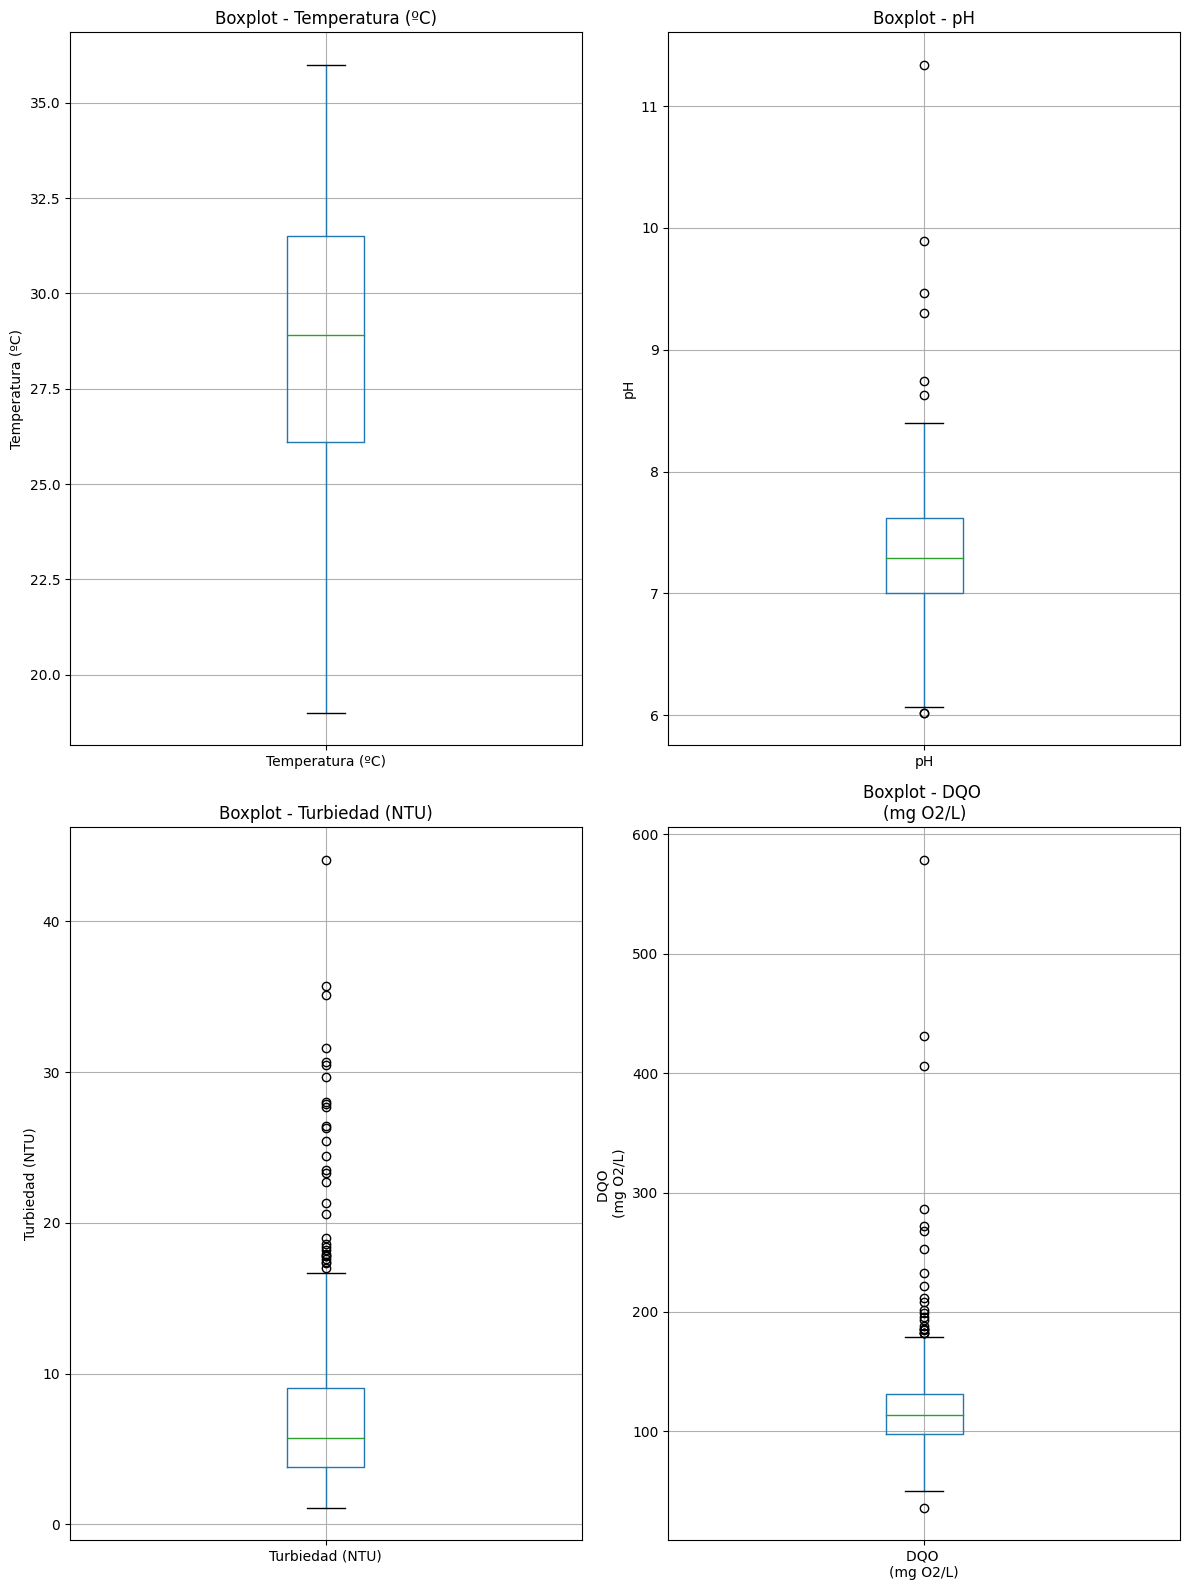

In [166]:
boxplots(data_lab)

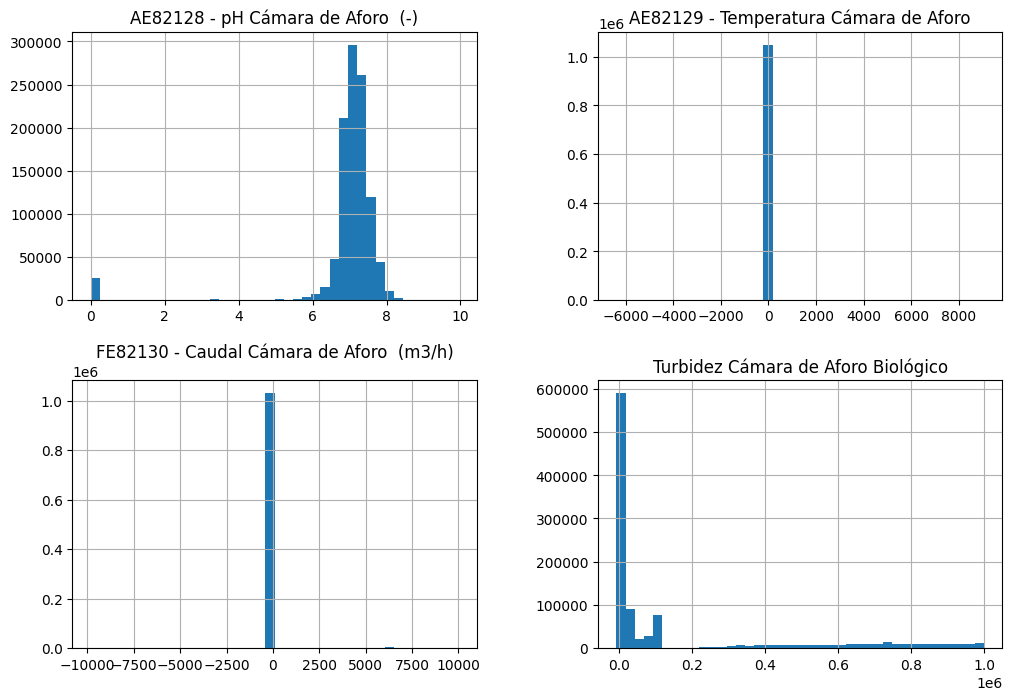

In [157]:
data_camara.select_dtypes(include=['number']).hist(bins=40, figsize=(12, 8))
plt.show()

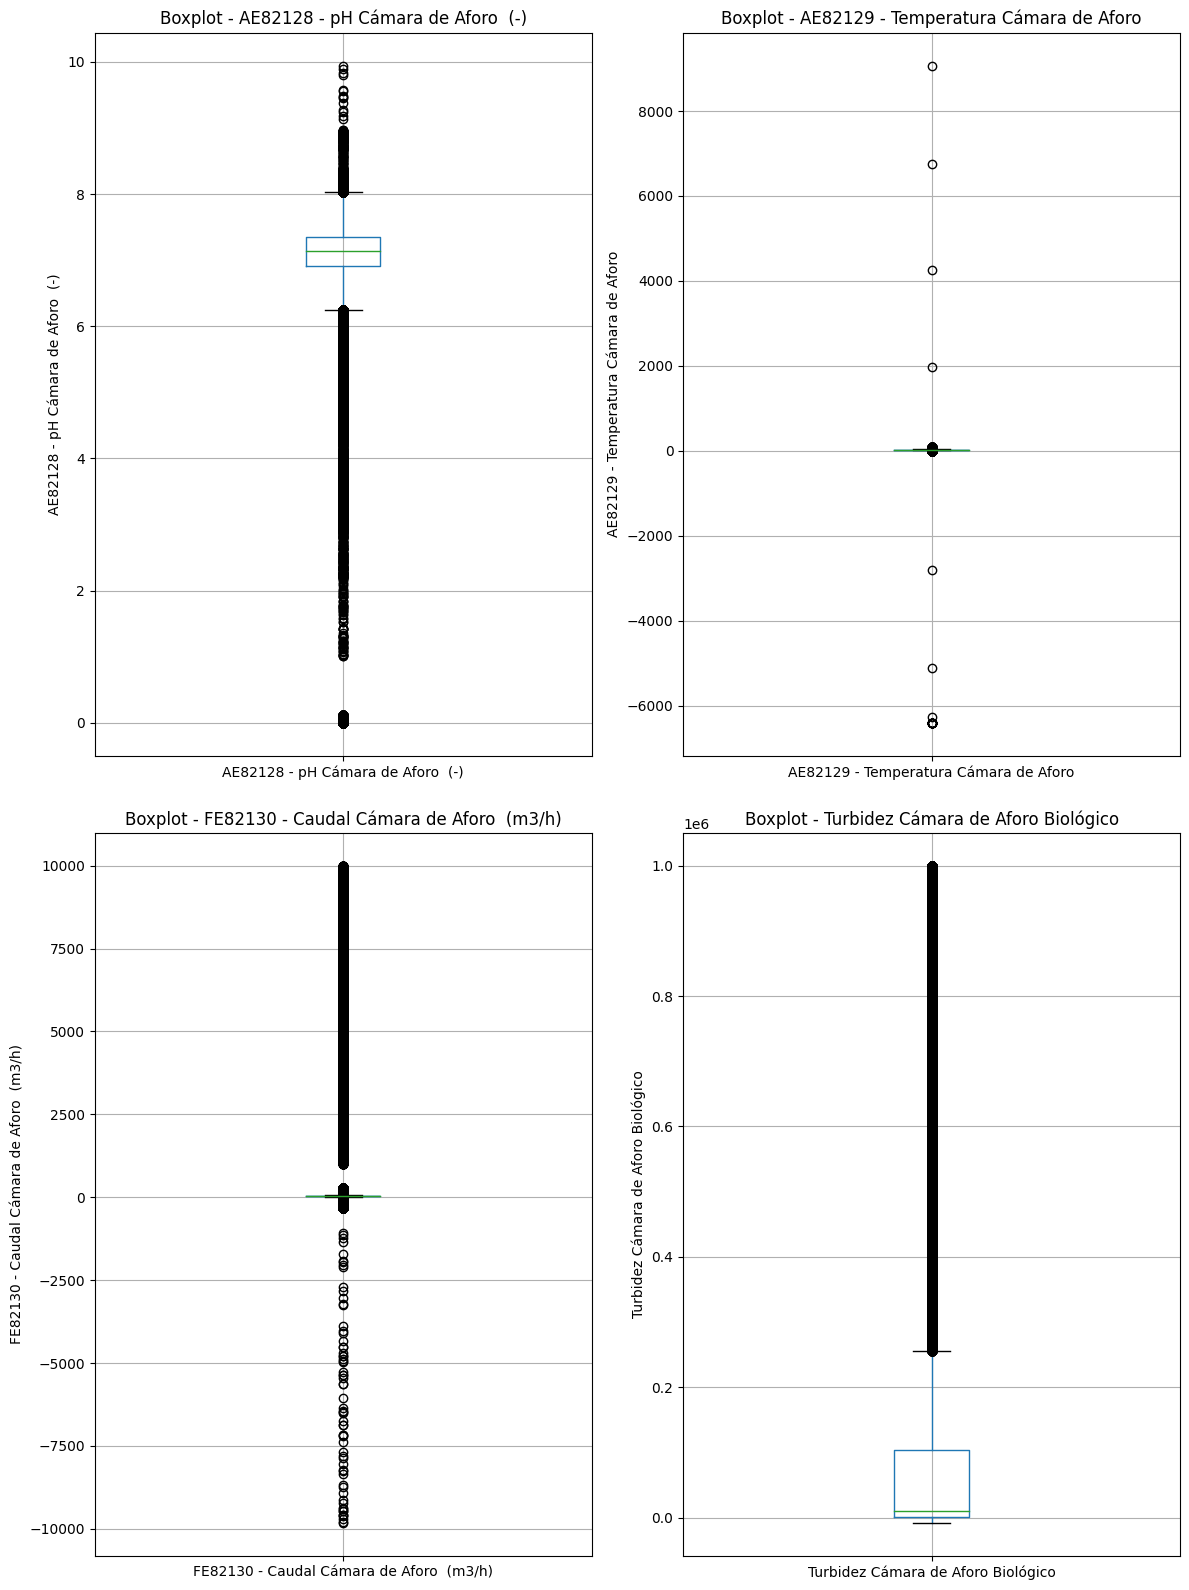

In [167]:
boxplots(data_camara)

## Relaciones en el tiempo

In [168]:
data_lab.select_dtypes(include=['number']).columns

Index(['Temperatura (ºC)', 'pH', 'Turbiedad (NTU)', 'DQO \n(mg O2/L)'], dtype='object')

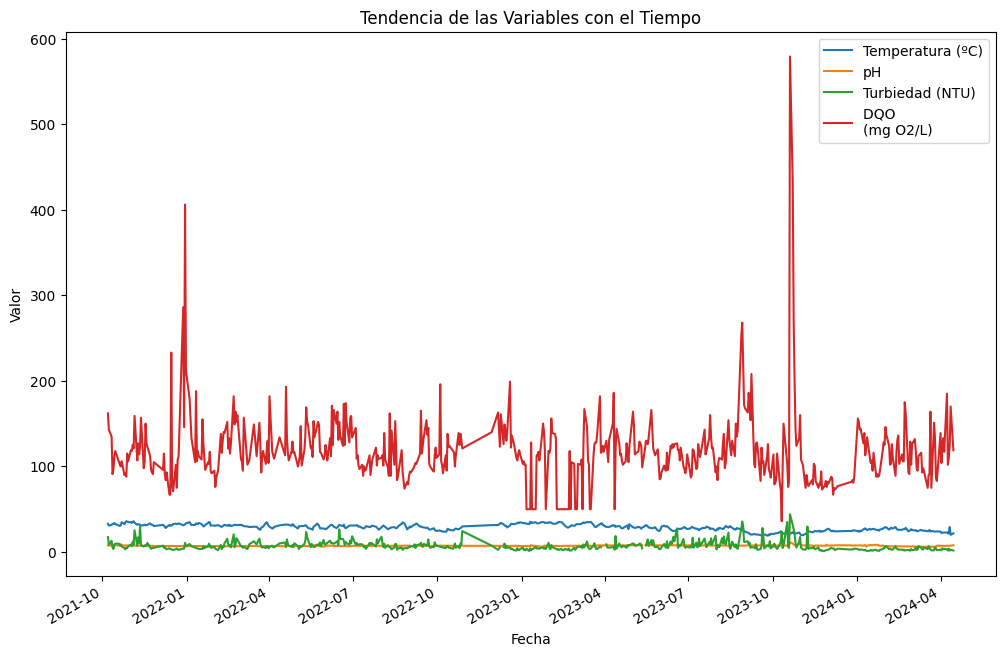

In [169]:
data_lab.set_index('Fecha').select_dtypes(include=['number']).plot(figsize=(12, 8))
plt.title('Tendencia de las Variables con el Tiempo')
plt.ylabel('Valor')
plt.show()


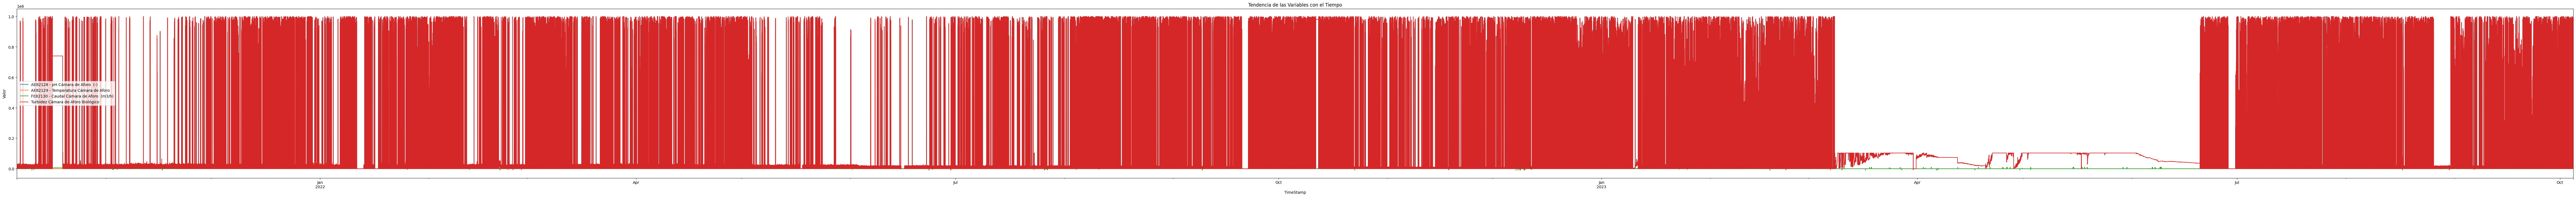

In [172]:
data_camara.set_index('TimeStamp').select_dtypes(include=['number']).plot(figsize=(1, 8))
plt.title('Tendencia de las Variables con el Tiempo')
plt.ylabel('Valor')
plt.show()

In [ ]:
# funcion para nada tomada prestada de otro proyecto mio lol

def plot_categorical_numerical(df, categorical_col, numerical_col, summary_ = False):
    # Calcular la media de la columna numérica por cada categoría
    summary = df.groupby(categorical_col)[numerical_col].mean().reset_index()

    plt.figure(figsize=(12, 6))

    sns.barplot(x=categorical_col, y=numerical_col, data=df, palette= 'Blues')
    media_numerica = df[numerical_col].mean()
    plt.axhline(y=media_numerica, color='red', linestyle='--', label='Media')

    plt.xlabel(categorical_col)
    plt.ylabel(f'Media de {numerical_col}')
    plt.title(f'Relación entre {categorical_col} y {numerical_col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    if summary_ == True:
        return summary

In [ ]:
plot_categorical_numerical(data_lab, 'Hora', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'Fecha', 'DQO \n(mg O2/L)')

No se ve un carajo de fecha asique hago mini tratamiento

In [ ]:
data_lab['DIA'] = data_lab['Fecha'].dt.day
data_lab['MES'] = data_lab['Fecha'].dt.month
data_lab['ANO'] = data_lab['Fecha'].dt.year

plot_categorical_numerical(data_lab, 'DIA', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'MES', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'ANO', 'DQO \n(mg O2/L)')

Mucha consistencia en el tiempo no? o sea no tiene gran seasonality, lo que es bueno creo para una time series prediction

## Correlaciones entre variables

In [ ]:
corr_matrix = data_lab.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()